# Import all dependencies

In [1]:
from __future__ import print_function, division
from builtins import range, input

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, AveragePooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import cv2
from glob import glob



/Users/tinevimbo/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Defining paramenters

In [2]:
#define size to which images are to be resized
IMAGE_SIZE = [224, 224] # feel free to change depending on dataset

# training config:
epochs = 500
batch_size = 32

#define paths
covid_path = '/Users/tinevimbo/Desktop/Final/Research/COVID-19_Radiography_Dataset/COVID/Some'
noncovid_path = '/Users/tinevimbo/Desktop/Final/Research/COVID-19_Radiography_Dataset/Normal/Some'

# Use glob to grab images from path .jpg or jpeg
covid_files = glob(covid_path + '/*')
noncovid_files = glob(noncovid_path + '/*')

# print(covid_files)
# print(noncovid_files)

# Fetch Images and Class Labels

In [3]:
# Preparing Labels
covid_labels = []
noncovid_labels = []

covid_images=[]
noncovid_images=[]

import cv2 

for i in range(len(covid_files)):
    image = cv2.imread(covid_files[i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image,(224,224))
    covid_images.append(image)
    covid_labels.append('Chest_COVID')

for i in range(len(noncovid_files)):
    image = cv2.imread(noncovid_files[i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image,(224,224))
    noncovid_images.append(image)
    noncovid_labels.append('Chest_NonCOVID')


# Visualizing some images in datasets

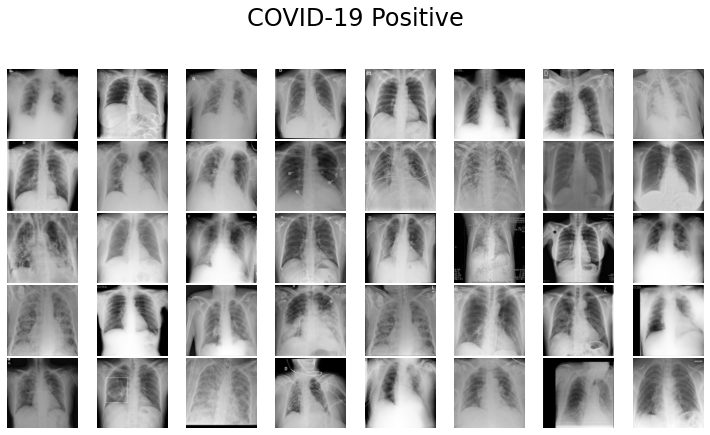

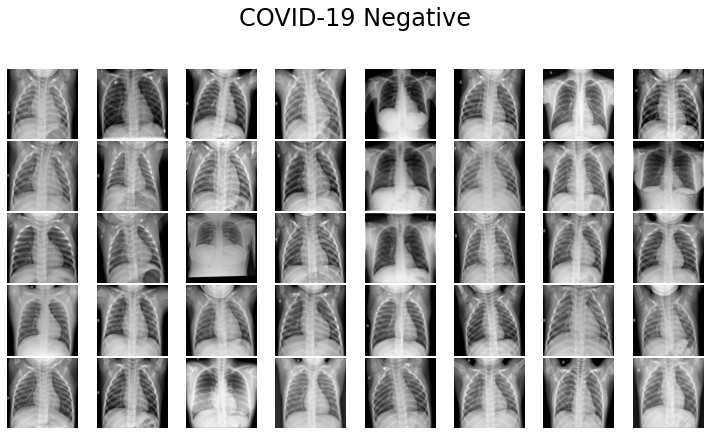

In [4]:

def plot_images(images, title):
    nrows, ncols = 5,8
    figsize = [10, 6]

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, facecolor=(1, 1, 1))

    for i, axi in enumerate(ax.flat):
        axi.imshow(images[i])
        axi.set_axis_off()

    plt.suptitle(title, fontsize=24)
    plt.tight_layout(pad=0.2, rect=[0, 0, 1, 0.9])
    plt.show()
plot_images(covid_images, 'COVID-19 Positive')
plot_images(noncovid_images, 'COVID-19 Negative')

# Normalization

In [5]:
# normalize to interval of [0,1]
covid_images = np.array(covid_images) / 255
noncovid_images = np.array(noncovid_images) / 255

# Train, Test, Split

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical

# split into training and testing
covid_x_train, covid_x_test, covid_y_train, covid_y_test = train_test_split(
    covid_images, covid_labels, test_size=0.2)
noncovid_x_train, noncovid_x_test, noncovid_y_train, noncovid_y_test = train_test_split(
    noncovid_images, noncovid_labels, test_size=0.2)

X_train = np.concatenate((noncovid_x_train, covid_x_train), axis=0)
X_test = np.concatenate((noncovid_x_test, covid_x_test), axis=0)
y_train = np.concatenate((noncovid_y_train, covid_y_train), axis=0)
y_test = np.concatenate((noncovid_y_test, covid_y_test), axis=0)

# make labels into categories - either 0 or 1
y_train = LabelBinarizer().fit_transform(y_train)
y_train = to_categorical(y_train)

y_test = LabelBinarizer().fit_transform(y_test)
y_test = to_categorical(y_test)

# Visualizing images from training and testing set

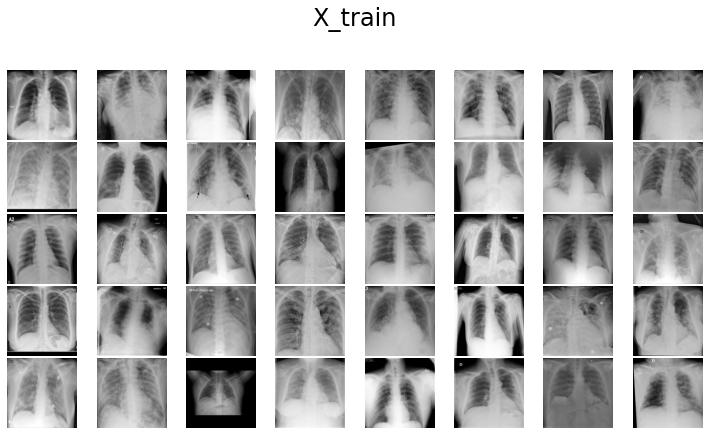

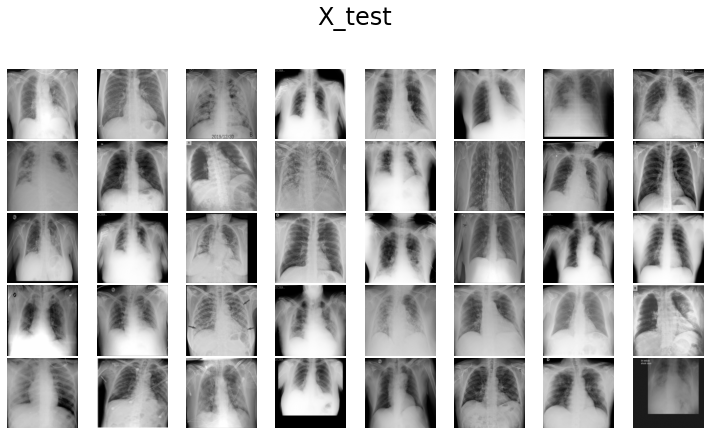

In [7]:
plot_images(covid_x_train, 'X_train')
plot_images(covid_x_test, 'X_test')
# y_train and y_test contain class lables 0 and 1 representing COVID and NonCOVID for X_train and X_test

In [8]:
print("Number of training images:", len(X_train))

Number of training images: 2400


In [9]:
print("Number of testing images:", len(X_test))

Number of testing images: 600


# Building model

In [10]:
res = ResNet50(weights="imagenet", include_top=False,
    input_tensor= Input(shape=(224, 224, 3)))

outputs = res.output
outputs = Flatten(name="flatten")(outputs)
outputs = Dropout(0.5)(outputs)
outputs = Dense(2, activation="softmax")(outputs)

model = Model(inputs=res.input, outputs=outputs)

for layer in res.layers:
    layer.trainable = False

model.compile(
        loss='categorical_crossentropy', 
        optimizer='adam', 
        metrics=['accuracy']
)

train_aug = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)


2022-10-23 20:32:37.463468: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

# Training model

In [12]:
history = model.fit(train_aug.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_test, y_test),
                    validation_steps=len(X_test) / 32,
                    steps_per_epoch=len(X_train) / 32,
                    epochs=500)

Epoch 1/500
75/75 [==============================] - 199s 3s/step - loss: 1.0322 - accuracy: 0.7129 - val_loss: 0.3511 - val_accuracy: 0.8783
Epoch 2/500
75/75 [==============================] - 209s 3s/step - loss: 0.4728 - accuracy: 0.8121 - val_loss: 0.3670 - val_accuracy: 0.8917
Epoch 3/500
75/75 [==============================] - 221s 3s/step - loss: 0.4443 - accuracy: 0.8313 - val_loss: 0.4152 - val_accuracy: 0.8883
Epoch 4/500
75/75 [==============================] - 227s 3s/step - loss: 0.5213 - accuracy: 0.8221 - val_loss: 0.3337 - val_accuracy: 0.9017
Epoch 5/500
75/75 [==============================] - 269s 4s/step - loss: 0.5092 - accuracy: 0.8379 - val_loss: 0.3699 - val_accuracy: 0.9050
Epoch 6/500
75/75 [==============================] - 320s 4s/step - loss: 0.5610 - accuracy: 0.8288 - val_loss: 0.3926 - val_accuracy: 0.9017
Epoch 7/500
75/75 [==============================] - 330s 4s/step - loss: 0.6129 - accuracy: 0.8258 - val_loss: 0.4282 - val_accuracy: 0.8800
Epoch 

75/75 [==============================] - 291s 4s/step - loss: 0.5476 - accuracy: 0.8875 - val_loss: 0.4021 - val_accuracy: 0.9217
Epoch 116/500
75/75 [==============================] - 291s 4s/step - loss: 0.7835 - accuracy: 0.8504 - val_loss: 1.2132 - val_accuracy: 0.8683
Epoch 117/500
75/75 [==============================] - 288s 4s/step - loss: 0.5783 - accuracy: 0.8867 - val_loss: 0.4266 - val_accuracy: 0.9250
Epoch 118/500
75/75 [==============================] - 290s 4s/step - loss: 0.5577 - accuracy: 0.8879 - val_loss: 0.4189 - val_accuracy: 0.9250
Epoch 119/500
75/75 [==============================] - 290s 4s/step - loss: 0.6184 - accuracy: 0.8746 - val_loss: 0.4458 - val_accuracy: 0.9217
Epoch 120/500
75/75 [==============================] - 297s 4s/step - loss: 0.5350 - accuracy: 0.8875 - val_loss: 0.5973 - val_accuracy: 0.9067
Epoch 121/500
75/75 [==============================] - 293s 4s/step - loss: 0.6009 - accuracy: 0.8767 - val_loss: 0.3886 - val_accuracy: 0.9300
Epoch 

Epoch 172/500
75/75 [==============================] - 268s 4s/step - loss: 0.5878 - accuracy: 0.8913 - val_loss: 0.4658 - val_accuracy: 0.9200
Epoch 173/500
75/75 [==============================] - 274s 4s/step - loss: 0.5320 - accuracy: 0.8908 - val_loss: 0.4021 - val_accuracy: 0.9083
Epoch 174/500
75/75 [==============================] - 261s 3s/step - loss: 0.4870 - accuracy: 0.8979 - val_loss: 0.5673 - val_accuracy: 0.9067
Epoch 175/500
75/75 [==============================] - 261s 3s/step - loss: 0.5582 - accuracy: 0.8783 - val_loss: 0.5326 - val_accuracy: 0.9083
Epoch 176/500
75/75 [==============================] - 264s 4s/step - loss: 0.5387 - accuracy: 0.8875 - val_loss: 0.4464 - val_accuracy: 0.9200
Epoch 177/500
75/75 [==============================] - 262s 3s/step - loss: 0.6204 - accuracy: 0.8842 - val_loss: 0.3798 - val_accuracy: 0.9283
Epoch 178/500
75/75 [==============================] - 261s 3s/step - loss: 0.6504 - accuracy: 0.8704 - val_loss: 0.3868 - val_accuracy:

Epoch 229/500
75/75 [==============================] - 304s 4s/step - loss: 0.7355 - accuracy: 0.8758 - val_loss: 0.5774 - val_accuracy: 0.8900
Epoch 230/500
75/75 [==============================] - 279s 4s/step - loss: 0.7033 - accuracy: 0.8750 - val_loss: 0.4932 - val_accuracy: 0.9117
Epoch 231/500
75/75 [==============================] - 268s 4s/step - loss: 0.6294 - accuracy: 0.8917 - val_loss: 0.4534 - val_accuracy: 0.9250
Epoch 232/500
75/75 [==============================] - 266s 4s/step - loss: 0.6837 - accuracy: 0.8771 - val_loss: 0.5340 - val_accuracy: 0.8967
Epoch 233/500
75/75 [==============================] - 266s 4s/step - loss: 0.6700 - accuracy: 0.8833 - val_loss: 0.7971 - val_accuracy: 0.9083
Epoch 234/500
75/75 [==============================] - 263s 4s/step - loss: 0.7470 - accuracy: 0.8746 - val_loss: 0.7585 - val_accuracy: 0.9067
Epoch 235/500
75/75 [==============================] - 276s 4s/step - loss: 0.6819 - accuracy: 0.8867 - val_loss: 0.5311 - val_accuracy:

Epoch 286/500
75/75 [==============================] - 287s 4s/step - loss: 0.6022 - accuracy: 0.8879 - val_loss: 0.4306 - val_accuracy: 0.9267
Epoch 287/500
75/75 [==============================] - 285s 4s/step - loss: 0.6908 - accuracy: 0.8763 - val_loss: 0.4503 - val_accuracy: 0.9217
Epoch 288/500
75/75 [==============================] - 285s 4s/step - loss: 0.6345 - accuracy: 0.8892 - val_loss: 0.4391 - val_accuracy: 0.9267
Epoch 289/500
75/75 [==============================] - 291s 4s/step - loss: 0.6552 - accuracy: 0.8758 - val_loss: 0.4455 - val_accuracy: 0.9250
Epoch 290/500
75/75 [==============================] - 285s 4s/step - loss: 0.5356 - accuracy: 0.8933 - val_loss: 0.4361 - val_accuracy: 0.9183
Epoch 291/500
75/75 [==============================] - 285s 4s/step - loss: 0.7200 - accuracy: 0.8750 - val_loss: 0.9993 - val_accuracy: 0.9050
Epoch 292/500
75/75 [==============================] - 285s 4s/step - loss: 0.7770 - accuracy: 0.8754 - val_loss: 0.9307 - val_accuracy:

Epoch 343/500
75/75 [==============================] - 279s 4s/step - loss: 0.7716 - accuracy: 0.8717 - val_loss: 0.5803 - val_accuracy: 0.9183
Epoch 344/500
75/75 [==============================] - 283s 4s/step - loss: 0.6241 - accuracy: 0.8913 - val_loss: 0.8299 - val_accuracy: 0.9083
Epoch 345/500
75/75 [==============================] - 279s 4s/step - loss: 0.6056 - accuracy: 0.8879 - val_loss: 0.8222 - val_accuracy: 0.9083
Epoch 346/500
75/75 [==============================] - 281s 4s/step - loss: 0.5859 - accuracy: 0.8938 - val_loss: 0.5773 - val_accuracy: 0.8833
Epoch 347/500
75/75 [==============================] - 282s 4s/step - loss: 0.6767 - accuracy: 0.8792 - val_loss: 0.5560 - val_accuracy: 0.9167
Epoch 348/500
75/75 [==============================] - 283s 4s/step - loss: 0.6630 - accuracy: 0.8858 - val_loss: 0.4446 - val_accuracy: 0.9200
Epoch 349/500
75/75 [==============================] - 281s 4s/step - loss: 0.6203 - accuracy: 0.8888 - val_loss: 0.4723 - val_accuracy:

Epoch 400/500
75/75 [==============================] - 275s 4s/step - loss: 0.6486 - accuracy: 0.8863 - val_loss: 1.0838 - val_accuracy: 0.9000
Epoch 401/500
75/75 [==============================] - 275s 4s/step - loss: 0.7550 - accuracy: 0.8800 - val_loss: 0.4698 - val_accuracy: 0.9183
Epoch 402/500
75/75 [==============================] - 277s 4s/step - loss: 0.6975 - accuracy: 0.8842 - val_loss: 0.5387 - val_accuracy: 0.9167
Epoch 403/500
75/75 [==============================] - 275s 4s/step - loss: 0.6320 - accuracy: 0.8983 - val_loss: 0.4763 - val_accuracy: 0.9217
Epoch 404/500
75/75 [==============================] - 274s 4s/step - loss: 0.6561 - accuracy: 0.8975 - val_loss: 0.4305 - val_accuracy: 0.9333
Epoch 405/500
75/75 [==============================] - 279s 4s/step - loss: 0.5759 - accuracy: 0.8950 - val_loss: 0.4029 - val_accuracy: 0.9167
Epoch 406/500
75/75 [==============================] - 275s 4s/step - loss: 0.6312 - accuracy: 0.8833 - val_loss: 0.4238 - val_accuracy:

Epoch 457/500
75/75 [==============================] - 274s 4s/step - loss: 0.6478 - accuracy: 0.8858 - val_loss: 0.4362 - val_accuracy: 0.9250
Epoch 458/500
75/75 [==============================] - 275s 4s/step - loss: 0.5754 - accuracy: 0.8921 - val_loss: 0.4023 - val_accuracy: 0.9217
Epoch 459/500
75/75 [==============================] - 267s 4s/step - loss: 0.5815 - accuracy: 0.8858 - val_loss: 0.4361 - val_accuracy: 0.9233
Epoch 460/500
75/75 [==============================] - 268s 4s/step - loss: 0.7244 - accuracy: 0.8683 - val_loss: 0.6636 - val_accuracy: 0.9117
Epoch 461/500
75/75 [==============================] - 285s 4s/step - loss: 0.5957 - accuracy: 0.8921 - val_loss: 0.4056 - val_accuracy: 0.9317
Epoch 462/500
75/75 [==============================] - 297s 4s/step - loss: 0.6375 - accuracy: 0.8858 - val_loss: 0.6794 - val_accuracy: 0.9100
Epoch 463/500
75/75 [==============================] - 327s 4s/step - loss: 0.7586 - accuracy: 0.8679 - val_loss: 0.6223 - val_accuracy:

In [13]:
model.save('resnet_chest_final.h5')

In [14]:
model.save_weights('resnetweights_chest.hdf5')

In [15]:
model = load_model('resnet_chest_final.h5')

# Making Predictions

In [16]:
y_pred = model.predict(X_test, batch_size=batch_size)

19/19 [==============================] - 52s 3s/step


# Visualizing Predictions

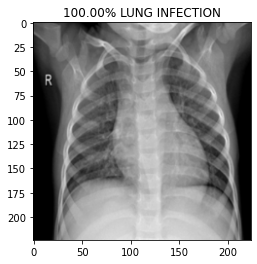

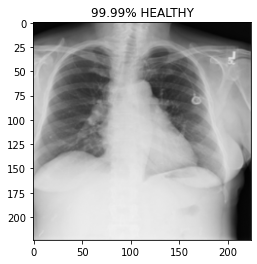

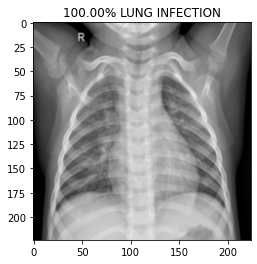

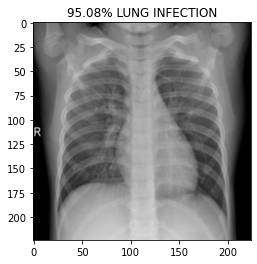

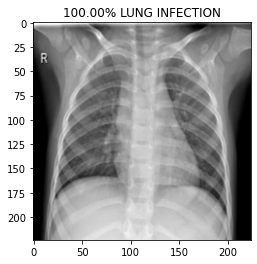

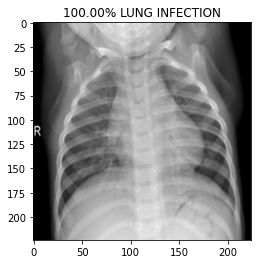

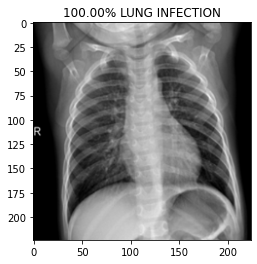

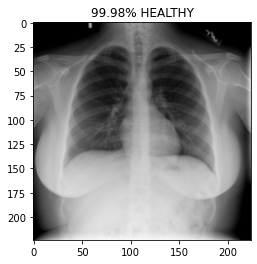

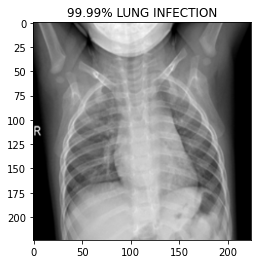

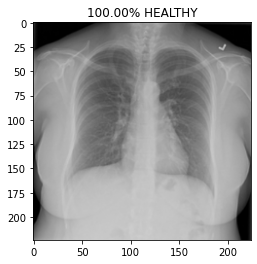

In [17]:
prediction=y_pred[0:10]
for index, probability in enumerate(prediction):
  if probability[1] > 0.5:
        plt.title('%.2f' % (probability[1]*100) + '% LUNG INFECTION')
  else:
        plt.title('%.2f' % ((1-probability[1])*100) + '% HEALTHY')
  plt.imshow(X_test[index])
  plt.show()

In [18]:
# Convert to Binary classes
y_pred_bin = np.argmax(y_pred, axis=1)
y_test_bin = np.argmax(y_test, axis=1)

# Plot ROC Curve

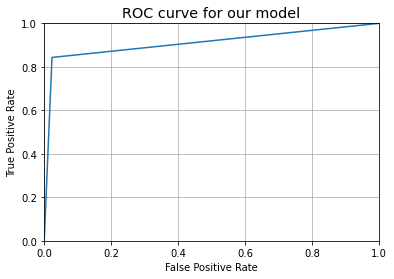

In [19]:
fpr, tpr, thresholds = roc_curve(y_test_bin, y_pred_bin)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for our model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

# Plot Confusion Matrix

Confusion Matrix without Normalization


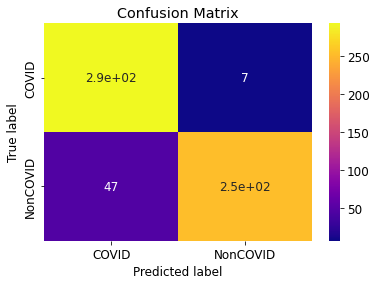

Confusion Matrix with Normalized Values


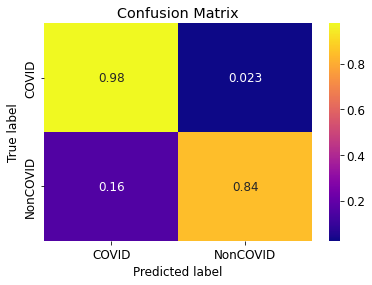

In [20]:
def plot_confusion_matrix(normalize):
  classes = ['COVID','NonCOVID']
  tick_marks = [0.5,1.5]
  cn = confusion_matrix(y_test_bin, y_pred_bin,normalize=normalize)
  sns.heatmap(cn,cmap='plasma',annot=True)
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)
  plt.title('Confusion Matrix')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

print('Confusion Matrix without Normalization')
plot_confusion_matrix(normalize=None)

print('Confusion Matrix with Normalized Values')
plot_confusion_matrix(normalize='true')

# Classification Report

In [21]:
from sklearn.metrics import classification_report
print(classification_report(y_test_bin, y_pred_bin))

              precision    recall  f1-score   support

           0       0.86      0.98      0.92       300
           1       0.97      0.84      0.90       300

    accuracy                           0.91       600
   macro avg       0.92      0.91      0.91       600
weighted avg       0.92      0.91      0.91       600



# Accuracy and Loss Plots

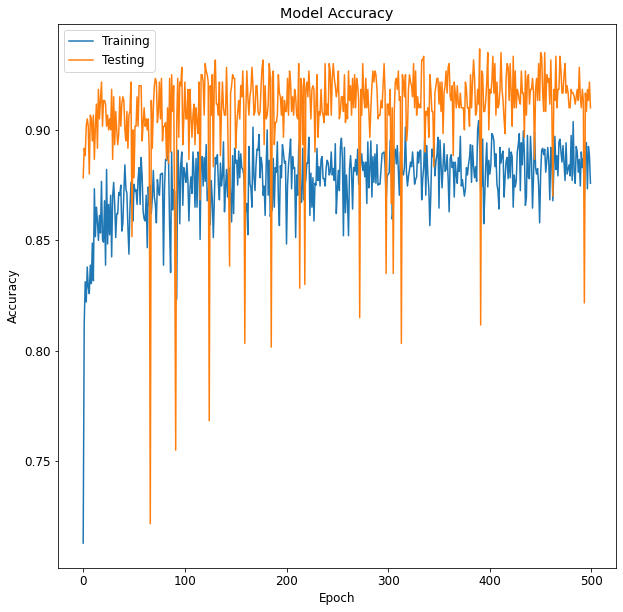

In [22]:
plt.figure(figsize=(10,10))

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('resnet_chest_accuracy.png')
plt.show()


# Model Loss

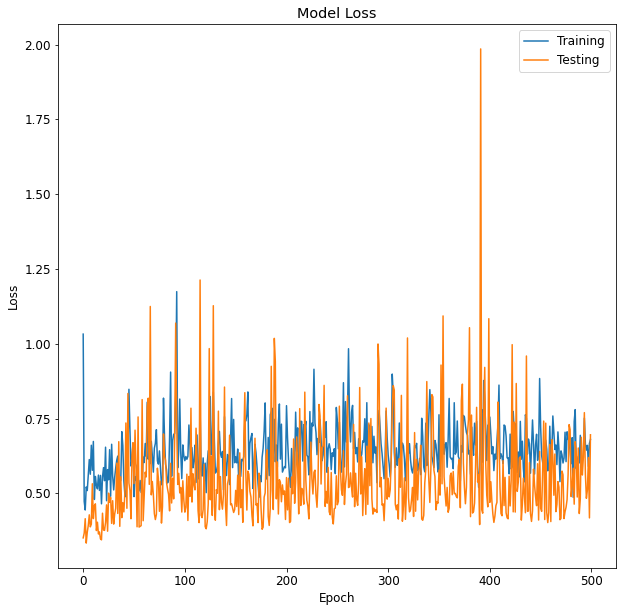

In [23]:
plt.figure(figsize=(10,10))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('resnet_chest_loss.png')
plt.show()